<a href="https://colab.research.google.com/github/vignesh-pala/NLP/blob/master/NLP_Ch11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenge 11 (NLP with Keras-TF2)**

Use the yelp review data set available at https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+S...

Create a NLP text classification model using CNNs and see if you can achieve more than 80% accuracy on TEST data.

In [19]:
import tensorflow 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import reuters
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers, backend
from keras.utils import np_utils

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
import string
#stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Read input from Google drive
df = pd.read_csv('/content/yelp_labelled.txt', names=['sentence', 'label'], sep='\t')

In [21]:
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [22]:
# check size of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [23]:
#check for null values
df.isnull().sum()

sentence    0
label       0
dtype: int64

In [24]:
#seperate sentence and labels
sentence = df['sentence'].values
label = df['label'].values
sentence[0]

'Wow... Loved this place.'

In [48]:
# Train Test & Validation Split
X_train, X_test, y_train, y_test = train_test_split(sentence, label, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(sentence, label, test_size=0.2, random_state=42)

 * Tokenize and Convert to Sequences


In [49]:
max_words = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
x_train_tkn = tokenizer.texts_to_sequences(X_train)
x_test_tkn = tokenizer.texts_to_sequences(X_test)
x_val_tkn = tokenizer.texts_to_sequences(X_val)
print(X_train[1])
print(x_train_tkn[1]) 

An excellent new restaurant by an experienced Frenchman.
[46, 144, 370, 66, 61, 46, 773, 774]


 Pad the vector to have fixed length

    Note: the max words in the sentences is only around 30, so set maxlen = 30

In [54]:
maxlen = 30
x_train_pad = preprocessing.sequence.pad_sequences(x_train_tkn, maxlen=maxlen,  padding='post')
x_test_pad = preprocessing.sequence.pad_sequences(x_test_tkn, maxlen=maxlen,  padding='post')
x_val_pad = preprocessing.sequence.pad_sequences(x_val_tkn, maxlen=maxlen,  padding='post')

In [55]:
x_train_pad[100]

array([ 17, 159,  14, 880,  88,   6,  29, 333, 410,  44,  24, 547, 881,
       278,   2,  17,  24,   1,  65, 331, 330,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [56]:
#Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1825

In [57]:
embedding_dim = 50

backend.clear_session()
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu', kernel_regularizer=l1(0.0001)))
model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(64, activation='relu'))
#model.add(BatchNormalization())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            91250     
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            16064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 107,975
Trainable params: 107,975
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(x_train_pad, y_train,
                    epochs=15,
                    batch_size=16,
                    verbose=True,
                    validation_data=(x_val_pad, y_val),
                    callbacks=[early_stop])

Epoch 1/15
50/50 [==============================] - 0s 7ms/step - loss: 0.7607 - accuracy: 0.5575 - val_loss: 0.7442 - val_accuracy: 0.5650
Epoch 2/15
50/50 [==============================] - 0s 5ms/step - loss: 0.7108 - accuracy: 0.7275 - val_loss: 0.6975 - val_accuracy: 0.6800
Epoch 3/15
50/50 [==============================] - 0s 5ms/step - loss: 0.5630 - accuracy: 0.8587 - val_loss: 0.5609 - val_accuracy: 0.7800
Epoch 4/15
50/50 [==============================] - 0s 5ms/step - loss: 0.3077 - accuracy: 0.9300 - val_loss: 0.4635 - val_accuracy: 0.8000
Epoch 5/15
50/50 [==============================] - 0s 6ms/step - loss: 0.1715 - accuracy: 0.9712 - val_loss: 0.4724 - val_accuracy: 0.8100
Epoch 6/15
50/50 [==============================] - 0s 5ms/step - loss: 0.1164 - accuracy: 0.9900 - val_loss: 0.4524 - val_accuracy: 0.8100
Epoch 7/15
50/50 [==============================] - 0s 5ms/step - loss: 0.0923 - accuracy: 0.9912 - val_loss: 0.5218 - val_accuracy: 0.8050
Epoch 8/15
50/50 [==

* As we can see in the below graph, the model is overfitting. 
* Tried different techniques like Dropout, Batchnormalization, Regularization, but its not improving the outcome

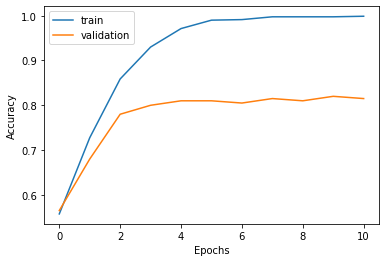

In [61]:
# plot history
# summarize history for accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.legend()
pyplot.show()

**Evaluate the model on Test data**

In [62]:
results = model.evaluate(x_test_pad, y_test, batch_size=64)
print("test loss = {}\ntest accuracy = {}".format(results[0], results[1]))

4/4 [==============================] - 0s 3ms/step - loss: 0.5293 - accuracy: 0.8150
test loss = 0.5293234586715698
test accuracy = 0.8149999976158142


**Appendix**

**References**:

http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

Learning task: Fine tune your understanding on loss functions and optimizers using

https://medium.com/data-science-group-iitr/loss-functions-and-optimization-algorithms-demystified-bb92daff331c

----------------------------------------------

https://www.kaggle.com/sanikamal/text-classification-with-python-and-keras

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

uses Glove emedding
https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

https://thedatafrog.com/en/articles/sentiment-analysis-convolutional-network/

https://thedatafrog.com/en/articles/text-preprocessing-machine-learning-yelp/


For Future enhancements:

Cleanup text (using below code) and retrain the model.

In [ ]:
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)

In [ ]:
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()

  #remove punctuations
	tokens = [w.translate(table) for w in tokens]

	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]

	tokens = [w for w in tokens if  w not in stop_words]

	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]

	return tokens

In [ ]:
X_train1 = [clean_doc(t) for t in X_train]
X_test1 = [clean_doc(t) for t in X_test]
X_train1[4]

['Just', 'lunch', 'great', 'experience']